<font size="6">Lending Club Analysis</font>

Objective:
- Tasked by an Investment firm to analyze the possibility of investing in Lending Club loans as part of our portfolio. 


Tasks:
-	Perform EDA to understand dataset.
-	Impute missing data.
-	Select features, removing ones that could lead to data leakage or are unimportant.
-	Train models to predict loan defaults.
-	Calculate the best CAGR.
-	Compare with other investment assets.
-	Conclusions.
-	Future work.

## Load Packages and Data

In [247]:
import numpy as np 
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from catboost import CatBoostClassifier, Pool, metrics, cv, CatBoostRegressor
from sklearn import metrics
from collections import OrderedDict
import numpy_financial as npf
from pandas.plotting import table 

plt.style.use("default")
sns.set_style('whitegrid')
%matplotlib inline

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [136]:
data = pd.read_csv("G:\\Lending Club Data Files\\accepted_2007_to_2018Q4.csv")
#data = pd.read_csv("data\accepted_2007_to_2018Q4.csv")

C:\Users\Daniel\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning:

Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.



In [137]:
data.sample(1)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1342332,10705015,NaN,25000.00,25000.00,25000.00,36 months,11.99,830.24,B,B3,senior associate,6 years,MORTGAGE,90000.00,Verified,Jan-2014,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 01/20/14 > the loan is str...,debt_consolidation,Debt consolidation,531xx,WI,14.27,0.00,Aug-1996,740.00,744.00,2.00,NaN,NaN,10.00,0.00,25948.00,66.50,24.00,f,0.00,0.00,29888.57,29888.57,25000.00,4888.57,0.00,0.00,0.00,Jan-2017,830.17,NaN,Jan-2017,724.00,720.00,0.00,NaN,1.00,Individual,NaN,NaN,NaN,0.00,0.00,201008.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39000.00,NaN,NaN,NaN,4.00,20101.00,13052.00,66.50,0.00,0.00,149.00,209.00,14.00,5.00,5.00,14.00,NaN,5.00,NaN,0.00,3.00,3.00,4.00,7.00,8.00,4.00,10.00,3.00,10.00,0.00,0.00,0.00,2.00,100.00,25.00,0.00,0.00,233156.00,38722.00,39000.00,24024.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## Understanding the Data

In [138]:
data.shape

(2260701, 151)

### Exploring Value of Loans Issued

In [139]:
loans_issued = data.groupby('issue_d')['loan_amnt'].sum().reset_index()
loans_issued['issue_d'] = pd.DatetimeIndex(loans_issued['issue_d']).year
loans_issued = loans_issued.groupby('issue_d').sum().reset_index()

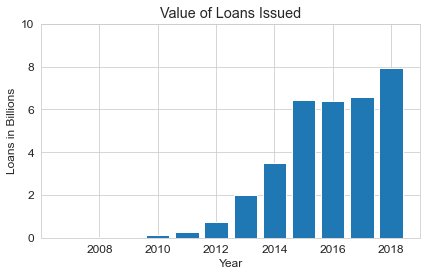

In [140]:
plt.rcParams.update({'font.size': 12})
f, ax = plt.subplots()
ax.bar(loans_issued.issue_d, loans_issued.loan_amnt)
# ax.tick_params(axis='y')
ax.set_ylabel('Loans in Billions')
ax.set(xlabel="Year",
      title="Value of Loans Issued")
f.tight_layout()  # otherwise the right y-label is slightly clipped
plt.yticks(ax.get_yticks(), (ax.get_yticks() / 1000000000).astype(int))
# plt.xticks(loans_issued.issue_d)
plt.show()
f.savefig('./images/value_of_loans.png', facecolor=f.get_facecolor(), transparent=True, dpi=500)

### Exploring the Target Variable

In [141]:
loan_status = data['loan_status'].value_counts().reset_index()
loan_status.columns = ['loan_status', 'count']
loan_status = loan_status[loan_status['loan_status'].isin(['Fully Paid', 'Charged Off'])]

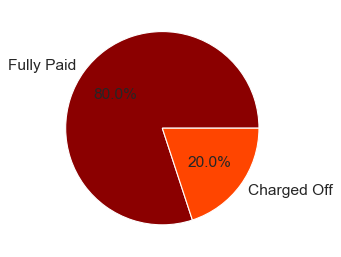

In [142]:
plt.rcParams['figure.dpi'] = 80
plt.rcParams.update({'font.size': 14})
f, ax = plt.subplots()
types = ['Fully Paid', 'Charged Off']
ax.pie(x=loan_status['count'], labels = types, autopct='%1.1f%%', colors=('darkred','orangered'))
plt.show()
f.savefig('./images/pie_loan_status.png', facecolor=f.get_facecolor(), transparent=True, dpi=500)

As expected we are dealing with an imbalanced dataset since one class represents only 20% of observations. In this case the null model, always guessing the fully paid class, would have an 80% accuracy. We have to work to improve on this null model. Using metrics other than accuracy such as specificity, sensitivity, F1, and area under the curve (AUC) we should get a better diagnostic of how well our model is working. In any case, our final performance metric should be one that measures the profit generated by the investor.

We might also want to do under-sampling or over-sampling, which either reduces the number of samples of the over represented observations or increases the under represented class. Furthermore, some algorithms on scikit learn can also account for unbalanced models.

### Exploring Loan Amount and Income

In [143]:
data['issue_d'] = pd.to_datetime(data['issue_d'])

In [144]:
loan_percent_income = data.groupby(pd.Grouper(key='issue_d',freq='Y'))[['loan_amnt', 'annual_inc']].mean().reset_index()
loan_percent_income['percent'] = loan_percent_income['loan_amnt']/loan_percent_income['annual_inc']
loan_percent_income['issue_d'] = pd.DatetimeIndex(loan_percent_income['issue_d']).year

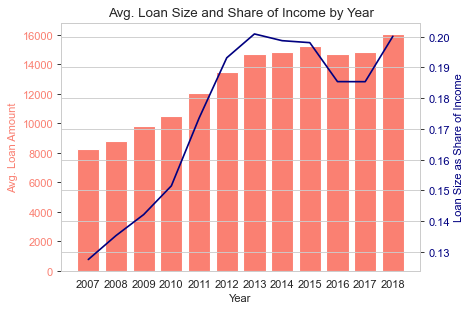

In [145]:
plt.rcParams.update({'font.size': 10})
f, ax = plt.subplots()
ax.grid(False)
color = 'salmon'
ax.bar(loan_percent_income.issue_d, loan_percent_income.loan_amnt, color=color)
ax.tick_params(axis='y', labelcolor=color)
ax.set_ylabel('Avg. Loan Amount', color=color)
ax.set(xlabel="Year",
      title="Avg. Loan Size and Share of Income by Year")

ax2 = ax.twinx()

color = 'navy'
ax2.set_ylabel('Loan Size as Share of Income', color=color)  # we already handled the x-label with ax1
ax2.plot(loan_percent_income.issue_d, loan_percent_income.percent, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks(loan_percent_income.issue_d)

f.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
f.savefig('./images/avg_loan_byyear.png', facecolor=f.get_facecolor(), transparent=True, dpi=500)

### Exploring Loan Purpose

In [146]:
purpose = data.groupby([pd.Grouper(key='issue_d',freq='Y'), 'purpose']).size().reset_index()
purpose.columns = ['issue_d','purpose','count']
purpose['issue_d'] = pd.DatetimeIndex(purpose['issue_d']).year
purpose = purpose.pivot(index='issue_d', columns='purpose', values='count')
purpose = purpose.reset_index()
purpose['sum'] = purpose.iloc[:,1:].sum(axis=1)
purpose = purpose.fillna(0)
purpose.iloc[:, 1:-1]=purpose.iloc[:, 1:-1].div(purpose['sum'], axis=0)
purpose.drop('sum', axis=1, inplace=True)
purpose.sort_values(by=11, axis=1, ascending=False, inplace=True)

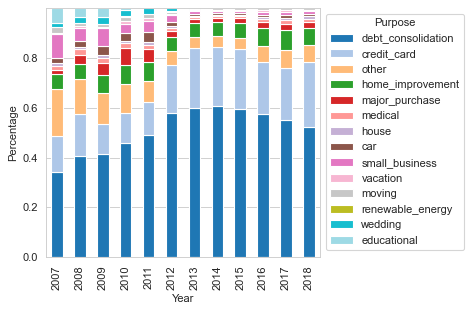

In [147]:
ax = purpose.plot(x='issue_d', kind='bar', stacked=True, colormap='tab20')
ax.set_ylabel('Percentage')
ax.set_xlabel('Year')
plt.legend(title='Purpose', bbox_to_anchor=(1.0, 1), loc='upper left')
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('./images/purpose.png', dpi=500)
plt.show()

### Exploring Location of Borrowers

In [148]:
states = data.groupby(['addr_state','issue_d'])['loan_amnt'].sum().reset_index()
states['issue_d'] = pd.DatetimeIndex(states['issue_d']).year
states = states.groupby(['addr_state','issue_d'])['loan_amnt'].sum().reset_index()
states['loan_amnt'] = round(states['loan_amnt']/1000000)
states = states[states['issue_d']==2018]

In [149]:
fig = go.Figure(data=go.Choropleth(
    locations=states['addr_state'], # Spatial coordinates
    z = states['loan_amnt'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = '2018 Loans Allocated by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()
fig.write_image("./images/loans_by_state.png", scale=2)

### Exploring Interest Rates

In [150]:
int_rate = data[['issue_d','int_rate']].copy()
int_rate['issue_d'] = pd.DatetimeIndex(int_rate['issue_d']).year
int_rate.dropna(inplace=True)
int_rate['issue_d'] = int_rate['issue_d'].astype(int)

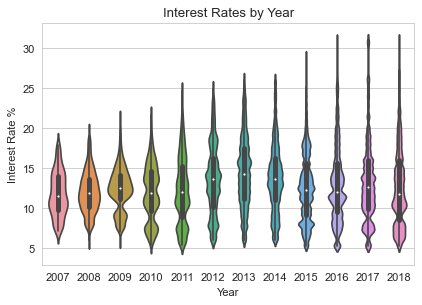

In [151]:
plt.subplots(dpi = 80)
sns.set_theme(style="whitegrid", font_scale=1.0)
g = sns.violinplot(data=int_rate, x="issue_d", y="int_rate", size="size")
g.set_title('Interest Rates by Year')
g.set_ylabel('Interest Rate %')
g.set_xlabel('Year')
plt.savefig('./images/int_rates.png', dpi=500)

## Preparing the Data for the Models

### Selecting Features

In [152]:
for e, column in enumerate(data.columns):
    print (e, column)

0 id
1 member_id
2 loan_amnt
3 funded_amnt
4 funded_amnt_inv
5 term
6 int_rate
7 installment
8 grade
9 sub_grade
10 emp_title
11 emp_length
12 home_ownership
13 annual_inc
14 verification_status
15 issue_d
16 loan_status
17 pymnt_plan
18 url
19 desc
20 purpose
21 title
22 zip_code
23 addr_state
24 dti
25 delinq_2yrs
26 earliest_cr_line
27 fico_range_low
28 fico_range_high
29 inq_last_6mths
30 mths_since_last_delinq
31 mths_since_last_record
32 open_acc
33 pub_rec
34 revol_bal
35 revol_util
36 total_acc
37 initial_list_status
38 out_prncp
39 out_prncp_inv
40 total_pymnt
41 total_pymnt_inv
42 total_rec_prncp
43 total_rec_int
44 total_rec_late_fee
45 recoveries
46 collection_recovery_fee
47 last_pymnt_d
48 last_pymnt_amnt
49 next_pymnt_d
50 last_credit_pull_d
51 last_fico_range_high
52 last_fico_range_low
53 collections_12_mths_ex_med
54 mths_since_last_major_derog
55 policy_code
56 application_type
57 annual_inc_joint
58 dti_joint
59 verification_status_joint
60 acc_now_delinq
61 tot_col

Using the dictionary with the descriptions I will review the features available to determine which were obtained after the loan origination to avoid data leakage. We should only use information available at loan origination in order to avoid having a model that overestimates its predictive power. The following are features I found to be available at origination and that are relevant:

- id, loan_amnt, term, int_rate, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, loan_status (target), purpose, zip_code, addr_state, dti, earliest_cr_line, fico_range_low, fico_range_high, open_acc, pub_rec, initial_list_status, application_type, annual_inc_joint, dti_joint, verification_status_joint, pub_rec_bankruptcies

Column index: 0, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 20, 22, 23, 24, 26, 27, 28, 32, 33, 37, 56, 57, 58, 59, 109

In [153]:
# On new training add column index 10
df = data.iloc[:,[0,2,5,6,8,9,
                  
                  11,12,13,14,16,20,22,23,24,26,27,28,32,33,37,56,57,58,59,109]]

### Filtering Rows that can be Used to Train our Model

Our analysis should only include observations where the target variable, loan_status, has a definite status in order to have a target that can be used to train our models. In this case, either the loan_status is "Fully Paid" or "Charged Off", which means it defaulted.

In [154]:
data.loan_status.value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [155]:
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

###  Understanding and Dealing with the Missing Data

In [156]:
nullseries = df.isnull().sum()
nullseries[nullseries > 0].sort_values(ascending=False)

verification_status_joint    1319715
dti_joint                    1319513
annual_inc_joint             1319510
emp_length                     78511
pub_rec_bankruptcies             697
dti                              374
zip_code                           1
dtype: int64

It seems most of the missing values for the joint data are missing because they do not apply since not all loan applicants do so with another person. 

Next we will explore the relation between emp_length and default rate to see if there is any correlation which could indicate that it is missing not at random.

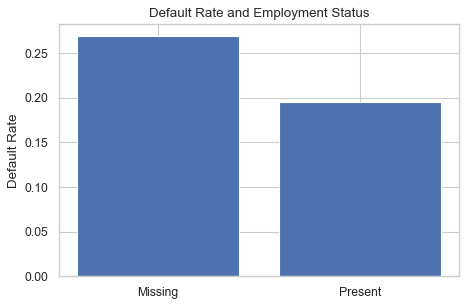

In [157]:
employment = df[['emp_length','loan_status']].copy()
employment['emp_length'] = employment['emp_length'].fillna(value='Missing')
employment['emp_length'] = employment['emp_length'].apply(lambda x: 'Missing' if x =='Missing' else 'Present')
employment['loan_status'] = employment['loan_status'].apply(lambda x: 1 if x =='Charged Off' else 0)
employment = employment.groupby('emp_length')['loan_status'].mean().reset_index()

#Graph

f, ax = plt.subplots()
ax.bar(employment.emp_length, employment.loan_status)
ax.set_ylabel('Default Rate')
ax.set(xlabel=None,
      title="Default Rate and Employment Status")
f.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
f.savefig('./images/default_rate_employment.png', facecolor=f.get_facecolor(), transparent=True, dpi=500)

It seems clear that there is a relationship between there being a missing value in the emp_status feature and the default rate of the loan, which seems to indicate that it is missing not at random. What this means is that the applicant is probably not disclosing this information if he is unemployed.

Since we will be using models that can deal with missing values we will not impute the missing values but it is good to know that this effect is probably present.

We will check if there seems to be the same effect for the other missing values, bankruptcies and dti.

In [158]:
bankruptcies = df[['pub_rec_bankruptcies','loan_status']].copy()
bankruptcies['pub_rec_bankruptcies'] = bankruptcies['pub_rec_bankruptcies'].fillna(value='Missing')
bankruptcies['pub_rec_bankruptcies'] = bankruptcies['pub_rec_bankruptcies'].apply(lambda x: 'Missing' if x =='Missing' else 'Present')
bankruptcies['loan_status'] = bankruptcies['loan_status'].apply(lambda x: 1 if x =='Charged Off' else 0)
bankruptcies = bankruptcies.groupby('pub_rec_bankruptcies')['loan_status'].mean().reset_index()
print(bankruptcies)

print()

dti = df[['dti','loan_status']].copy()
dti['dti'] = dti['dti'].fillna(value='Missing')
dti['dti'] = dti['dti'].apply(lambda x: 'Missing' if x =='Missing' else 'Present')
dti['loan_status'] = dti['loan_status'].apply(lambda x: 1 if x =='Charged Off' else 0)
dti = dti.groupby('dti')['loan_status'].mean().reset_index()
print(dti)

  pub_rec_bankruptcies  loan_status
0              Missing         0.17
1              Present         0.20

       dti  loan_status
0  Missing         0.19
1  Present         0.20


There seems to be some difference but not as much and the effect seems to be contrary, if it is missing the chance of default goes down. Furthermore, the sample size is much smaller so I don't think I can come to a conclusion on this matter.

In [159]:
df[df['zip_code'].isnull() == True]

,id,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,zip_code,addr_state,dti,earliest_cr_line,fico_range_low,fico_range_high,open_acc,pub_rec,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint,pub_rec_bankruptcies
1736050,96387212,5600.00,36 months,15.99,C,C5,10+ years,MORTGAGE,40000.00,Verified,Fully Paid,debt_consolidation,NaN,AL,22.86,Jul-2005,670.00,674.00,8.00,1.00,f,Individual,NaN,NaN,NaN,1.00


### Feature Transformation and Dummyfing

Here we will prepare the data to be able to be properly fed into the models. Based on my research I have chosen to use CatBoost as it seems to have the best performance both on results and speeds. This model does not need much pre-processing of the data, for example categorical features have to be specified using an index instead of needing label encoding.

In [160]:
#Only taking a sample of the total dataset in order to reduce training time while testing. Might increase later.
df_sample = df.sample(frac=0.1, random_state=1)
df_sample.shape

(134531, 26)

In [161]:
#Separating the target variable

X = df_sample.drop('loan_status', axis=1)
y = df_sample.loan_status

In [162]:
#Converting objects to strings

for column in X.columns:
    if (X[column].dtypes != float):
        X[column] = X[column].astype(str)

In [163]:
#Creating an index of the categorical features to point to the model
#print(X.dtypes)
cat_feat_index = np.where(X.dtypes != float)[0]
cat_feat_index

array([ 0,  2,  4,  5,  6,  7,  9, 10, 11, 12, 14, 19, 20, 23],
      dtype=int64)

### Train Test Split

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=72)

## Loan Default Model - Catboost

### Cross Validation Training

Important parameters and notes on how to use Catboost:

- Pool: a function which serves to pass the data to the model.

- eval_metric: Parameter for CatBoostClassifier. Its used for early stopping and selection of best iteration. We wan to use 'AUC'.

- metric_period: how many periods does it calculate the evaluation metric, might speed it up. Use an integer maybe 10 or 20.

- Stratified: Parameter for CV that helps the keep proportion of classes in the CV splits the same as the original data. Important to keep it True.

- auto_class_weights: Automatically calculate class weights based either on the total weight or the total number of objects in each class. The values are used as multipliers for the object weights. Using 'Balanced' will help the model deal with the fact that we have an imbalanced dataset.

- early_stopping_rounds: CatBoostClassifier that tells the model to stop training after X number of iterations which do not improve score. Using 20 for a model less than 1000 iterations is good.

- plot: Used when doing .fit() it will help visualize the training in real time if set to True.

- eval_set: Tests model to this evaluation dataset (X_test, y_test) to give you the result on it.

- depth: CatBoostClassifier param that signals depth of tree, default is 6 but more, like 10 could provide better results.

Some choices to do training: 

1- Set number of iterations or use the default 1000 and the algorithm sets a appropriate learning rate for the number of iterations.

2- Set a learning rate to a small value, for example 0.03 which is a good value, and a large number of iterations such as 10,000 and use the overffiting detector (early_stopping_rounds) to stop when it does not improve for a certain number of iterations.

- predict_proba: When used on the fitted model will give you the estimated probabilities of belonging to the class. 

- get_feature_importance(prettified=True): When applied to a fitted model it gives the feature importances based on how much each variable change the prediction value.

Snapshotting can be used to stop and restart a model from the iteration it was stopped using the parameters on CatBoostClassifier save_snapshot=True, snapshot_file='snapshot.bkp', and snapshot_interval=600 (number of seconds between saves).

Strategy: Use Grid Search to test hyperparameters on subset of full dataset and then using the best parameters test on full dataset. After we save the model in order to avoid time spent retraining.

In [165]:
# pool0 = Pool(X_train, y_train, cat_features=cat_feat_index)
# pool1 = Pool(X_test, y_test, cat_features=cat_feat_index)

# model = CatBoostClassifier(eval_metric='AUC:hints=skip_train~false', iterations=10000, learning_rate=0.03,
#                            logging_level='Silent', early_stopping_rounds=50, auto_class_weights='Balanced')

# grid = {'depth': [6, 8, 10],
#         'l2_leaf_reg': [1, 3, 5, 7]}

# grid_search_result = model.grid_search(grid,
#                                 X=pool0,
#                                 cv=3,
#                                 stratified=True,
#                                 verbose=False,
#                                 plot=True)

### Training the Model with the Tuned Hyperparameters

In [166]:
# print('Best parameters:\n')
# print(grid_search_result['params'])

# model.set_params(**grid_search_result['params'])

In [167]:
model.get_params()

{'eval_metric': 'AUC:hints=skip_train~false',
 'od_wait': 50,
 'verbose': 0,
 'iterations': 10000,
 'logging_level': 'Silent',
 'auto_class_weights': 'Balanced',
 'l2_leaf_reg': 3,
 'loss_function': 'Logloss',
 'depth': 6,
 'metric_period': 10,
 'learning_rate': 0.03}

In [168]:
#Taking whole dataset for training of the model using the parameters selected through grid search
df.shape

(1345310, 26)

In [169]:
#Separating the target variable

X = df.drop('loan_status', axis=1)
y = df.loan_status

In [170]:
#Converting objects to strings

for column in X.columns:
    if (X[column].dtypes != float):
        X[column] = X[column].astype(str)

In [171]:
#Creating an index of the categorical features to point to the model
#print(X.dtypes)
cat_feat_index = np.where(X.dtypes != float)[0]
cat_feat_index

array([ 0,  2,  4,  5,  6,  7,  9, 10, 11, 12, 14, 19, 20, 23],
      dtype=int64)

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=72)

In [173]:
# pool0 = Pool(X_train, y_train, cat_features=cat_feat_index)
# pool1 = Pool(X_test, y_test, cat_features=cat_feat_index)

# model.fit(X_train,
#           y_train,
#           eval_set=pool1,
#           cat_features=cat_feat_index,
#           verbose=False,
#           plot=True
#           )

### Results

Saving model to avoid retraining

In [174]:
# model.save_model('G:\\Lending Club Data Files\\lending_club_catboost')

In [175]:
model = CatBoostClassifier()
model.load_model('G:\\Lending Club Data Files\\lending_club_catboost')

In [176]:
#Separating the target variable

X = df.drop('loan_status', axis=1)
y = df.loan_status

In [177]:
#Converting objects to strings

for column in X.columns:
    if (X[column].dtypes != float):
        X[column] = X[column].astype(str)

In [178]:
#Creating an index of the categorical features to point to the model
#print(X.dtypes)
cat_feat_index = np.where(X.dtypes != float)[0]
cat_feat_index

array([ 0,  2,  4,  5,  6,  7,  9, 10, 11, 12, 14, 19, 20, 23],
      dtype=int64)

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=72)

In [180]:
pool0 = Pool(X_train, y_train, cat_features=cat_feat_index)
pool1 = Pool(X_test, y_test, cat_features=cat_feat_index)

In [181]:
proba = model.predict_proba(pool1)
print("The best ROC AUC score is:")
print(round(metrics.roc_auc_score(y_test, proba[:, 1]),4))

The best ROC AUC score is:
0.7327


Getting feature importance

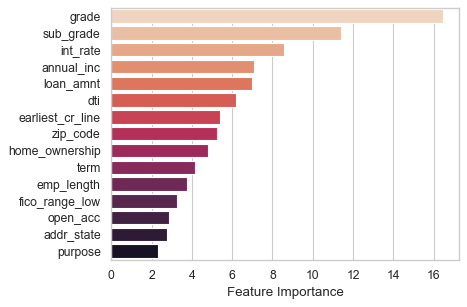

In [182]:
feature_importance = model.get_feature_importance(prettified=True)

f, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance[0:15], palette="rocket_r")
ax.set(ylabel="",
       xlabel="Feature Importance")
plt.tight_layout()
f.savefig('./images/feature_imp.png', dpi=500)

Something to note is that one of the most important features is grade and sub_grade, which is a rating given by Lending Club, which we do not know how is calculated and could change over time. This is cause for concern and could impact the results of our predictions in the future.

Plotting ROC curve

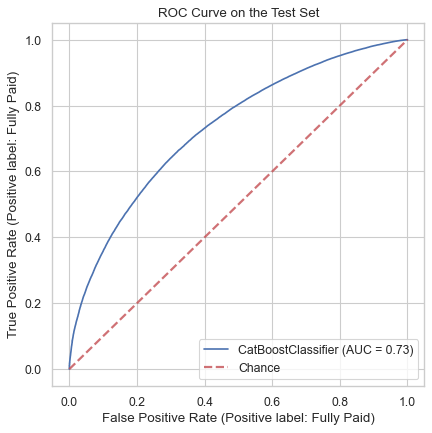

In [183]:
fig, ax = plt.subplots(figsize=(6, 6))
metrics.plot_roc_curve(model, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.set_title('ROC Curve on the Test Set')
ax.legend(loc='lower right')
plt.show()
fig.savefig('./images/ROC_curve.png', dpi=500)

Plotting confusion matrix and other metrics.

In [184]:
predictions = model.predict(pool1)

In [185]:
print(metrics.confusion_matrix(y_test, predictions, labels=['Charged Off', 'Fully Paid']))
print(metrics.classification_report(y_test, predictions, labels=['Charged Off', 'Fully Paid']))

[[ 36560  16862]
 [ 74089 141551]]
              precision    recall  f1-score   support

 Charged Off       0.33      0.68      0.45     53422
  Fully Paid       0.89      0.66      0.76    215640

    accuracy                           0.66    269062
   macro avg       0.61      0.67      0.60    269062
weighted avg       0.78      0.66      0.70    269062



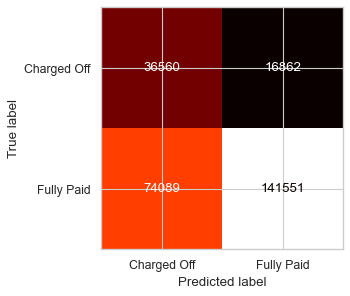

In [186]:
fig, ax = plt.subplots(figsize=(4, 4))
metrics.plot_confusion_matrix(model, X_test, y_test, labels=['Charged Off', 'Fully Paid'],
                             cmap='hot',colorbar=False, ax=ax)  
plt.show()
fig.tight_layout()
fig.savefig('./images/Confussion_matrix.png', dpi=500)

Since we are dealing with an unbalanced dataset we told the castboost model to auto balance the classes, that is why we are not maximizing accuracy but we are doing a similar job of predicting each label. We can observe this in the recall score, TP over TP plus FN, which is similar for both classes. Since the minority class is very costly, an defaulted loan, I wanted to take this approach.

## Back Testing Spread Thresholds

In this section we will back test loan portfolios, constructed using different methods, to determine what our hypothetical future potential returns could be based the results of this back test. One caveat is that the back test is done with a model trained with some loans that would not have been available when the tested loans were issued. However, these loans have never been seen by the model which provides some reassurance that the results can be replicated in the future.

I will calculate for each loan the value of the spread between its interest rate and its predicted probability of default. Meaning, I would determine which loans have the highest spread (most profitable loans adjusted by risk) and test different portfolios composed of the best values to determine how well they performed.

In [187]:
print('The classes are:',model.classes_,'\n',
      'We will keep only the model predicted probability of being Fully Paid.','\n')
proba_FP = proba[:,1]
proba_CO = proba[:,0]
print('Number of observations predicted on test set:',len(proba))

The classes are: ['Charged Off' 'Fully Paid'] 
 We will keep only the model predicted probability of being Fully Paid. 

Number of observations predicted on test set: 269062


### Creating a Dataframe with all the Relevant Information

We will recover all the data excluded because it was forward looking in order to properly be able to calculate the return function. Meaning we will get all the columns we excluded in the point "3.1 Selecting Features".

In [188]:
cols_to_use = data.columns.difference(X_test.columns, sort=False)

In [189]:
test_df = pd.merge(X_test, data[cols_to_use], how='left', left_index=True, right_index=True)

Adding the numpy array of calculated probabilities by the Catboost model to the dataframe containing all the loan information to test different thresholds and calculate Sharpe Ratio

In [190]:
test_df['proba_FP'] = proba_FP.tolist()
test_df['proba_CO'] = proba_CO.tolist()

In [191]:
test_df[test_df.loan_status=="Charged Off"].sample(1)

,id,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,zip_code,addr_state,dti,earliest_cr_line,fico_range_low,fico_range_high,open_acc,pub_rec,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint,pub_rec_bankruptcies,member_id,funded_amnt,funded_amnt_inv,installment,emp_title,issue_d,loan_status,pymnt_plan,url,desc,title,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,proba_FP,proba_CO
645695,112748781,7000.00,36 months,9.44,B,B1,1 year,MORTGAGE,115000.00,Not Verified,credit_card,551xx,MN,8.51,Mar-2005,675.00,679.00,11.00,0.00,w,Individual,NaN,NaN,nan,0.00,NaN,7000.00,7000.00,224.04,"Partner, Dir of PM",2017-07-01,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,Credit card refinancing,2.00,0.00,19.00,NaN,9615.00,75.70,23.00,0.00,0.00,2819.15,2819.15,1649.44,434.58,0.00,735.13,132.32,Apr-2018,224.04,NaN,Oct-2018,554.00,550.00,0.00,38.00,1.00,0.00,0.00,217668.00,2.00,2.00,0.00,1.00,16.00,49497.00,62.00,2.00,2.00,4908.00,71.00,12700.00,0.00,1.00,0.00,4.00,21767.00,3085.00,75.70,0.00,0.00,133.00,148.00,5.00,5.00,5.00,5.00,19.00,13.00,19.00,1.00,5.00,5.00,6.00,7.00,10.00,7.00,8.00,5.00,11.00,0.00,0.00,0.00,3.00,73.90,50.00,0.00,213155.00,59112.00,12700.00,36687.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0.75,0.25


In [192]:
test_df[test_df.loan_status=="Fully Paid"].sample(1)

,id,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,zip_code,addr_state,dti,earliest_cr_line,fico_range_low,fico_range_high,open_acc,pub_rec,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint,pub_rec_bankruptcies,member_id,funded_amnt,funded_amnt_inv,installment,emp_title,issue_d,loan_status,pymnt_plan,url,desc,title,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,proba_FP,proba_CO
2186215,93061456,10000.00,60 months,29.49,F,F2,2 years,MORTGAGE,60000.00,Source Verified,debt_consolidation,750xx,TX,4.96,Jul-2000,660.00,664.00,11.00,0.00,w,Individual,NaN,NaN,nan,0.00,NaN,10000.00,10000.00,320.41,Driver,2016-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,Debt consolidation,0.00,2.00,NaN,NaN,9300.00,59.20,16.00,0.00,0.00,15131.66,15131.66,10000.00,5131.66,0.00,0.00,0.00,Nov-2018,8099.02,NaN,Nov-2018,699.00,695.00,0.00,NaN,1.00,0.00,1109.00,68005.00,1.00,0.00,0.00,1.00,23.00,0.00,NaN,2.00,5.00,2808.00,58.00,15700.00,0.00,0.00,4.00,7.00,6182.00,2336.00,78.20,0.00,0.00,163.00,66.00,6.00,6.00,1.00,6.00,NaN,3.00,NaN,0.00,4.00,7.00,5.00,6.00,3.00,9.00,11.00,7.00,11.00,0.00,0.00,0.00,2.00,100.00,40.00,0.00,116879.00,9300.00,10700.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0.24,0.76


In [193]:
test_df['issue_d'] = pd.to_datetime(test_df['issue_d'])
test_df['last_pymnt_d'] = pd.to_datetime(test_df['last_pymnt_d'])

In [194]:
print(test_df.last_pymnt_d.isnull().sum())
print(test_df.issue_d.isnull().sum())

460
0


In [195]:
print(test_df[test_df['last_pymnt_d'].isnull()].groupby('loan_status').size())

print(test_df.shape[0])

value = float((test_df[test_df['last_pymnt_d'].isnull()].groupby('loan_status').size()/test_df.shape[0]))

print("{0:.5f}".format(value))

loan_status
Charged Off    460
dtype: int64
269062
0.00171


Some loans that are "Charged Off" do not have a last payment date. These represent a 0.17% of all loans so we will exclude them from the calculation. We assume in a real world scenario we will always have the last payment date since that will be the date we stop receiving payments.

In [196]:
test_df = test_df[test_df['last_pymnt_d'].notna()]
test_df.shape

(268602, 153)

Number of months between issuance and last payment

In [197]:
test_df['nb_months'] = ((test_df.last_pymnt_d - test_df.issue_d)/np.timedelta64(1, 'M'))
test_df['nb_months'] = test_df['nb_months'].astype(int)

### Adding Cashflows for Each Loan

Adding columns for every month and year and placing the loan amount as a negative cashflow on the issue date month.

In [198]:
# months = ["%.2d" % i for i in range(1,13)]
# years = ["%d" % i for i in range(2007,2019)]

# for year in years:
#     for month in months:
#         test_df[month+"-"+year] = np.where(test_df.issue_d.dt.strftime('%m-%Y') == month+"-"+year,
#                               -test_df['loan_amnt'], 0)     

Filling months with installments and last payment month with remaining difference between sum of all installments and the full total amount paid.

In [199]:
# for index in test_df.index:
#     months_list = pd.date_range(test_df.loc[index, 'issue_d'], test_df.loc[index, 'last_pymnt_d'],
#                                 freq='MS', closed='right').strftime("%m-%Y").tolist()
#     if test_df.loc[index, 'nb_months'] == 0:
#         test_df.loc[index, test_df.loc[index, 'issue_d'].strftime("%m-%Y")] = \
#         (-test_df.loc[index, 'loan_amnt']+test_df.loc[index, 'total_pymnt'])
        
#     else:
#         for month in months_list[0:-1]:
#             test_df.loc[index, month] = test_df.loc[index, 'installment']
#         test_df.loc[index, months_list[-1]] = \
#         (test_df.loc[index, 'total_pymnt']-(test_df.loc[index, 'installment']*len(months_list[0:-1])))

In [200]:
values = {'01-2019': 0, '02-2019': 0, '03-2019': 0}
test_df.fillna(value=values, inplace=True)

In [201]:
test_df.shape

(268602, 154)

In [202]:
# test_df.to_pickle("G:\\Lending Club Data Files\\test_df.pkl")

In [203]:
test_df = pd.read_pickle("G:\\Lending Club Data Files\\test_df.pkl")

In [204]:
test_df.sample(1)

,id,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,zip_code,addr_state,dti,earliest_cr_line,fico_range_low,fico_range_high,open_acc,pub_rec,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint,pub_rec_bankruptcies,acc_now_delinq,acc_open_past_24mths,all_util,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,debt_settlement_flag,debt_settlement_flag_date,deferral_term,delinq_2yrs,delinq_amnt,desc,disbursement_method,emp_title,funded_amnt,funded_amnt_inv,hardship_amount,hardship_dpd,hardship_end_date,hardship_flag,hardship_last_payment_amount,hardship_length,hardship_loan_status,hardship_payoff_balance_amount,hardship_reason,hardship_start_date,hardship_status,hardship_type,il_util,inq_fi,inq_last_12m,inq_last_6mths,installment,issue_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,last_pymnt_amnt,last_pymnt_d,loan_status,max_bal_bc,member_id,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,next_pymnt_d,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,orig_projected_additional_accrued_interest,out_prncp,out_prncp_inv,payment_plan_start_date,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pymnt_plan,recoveries,revol_bal,revol_bal_joint,revol_util,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_earliest_cr_line,sec_app_fico_range_high,sec_app_fico_range_low,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_mths_since_last_major_derog,sec_app_num_rev_accts,sec_app_open_acc,sec_app_open_act_il,sec_app_revol_util,settlement_amount,settlement_date,settlement_percentage,settlement_status,settlement_term,tax_liens,title,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,proba_FP,proba_CO,nb_months,01-2007,02-2007,03-2007,04-2007,05-2007,06-2007,07-2007,08-2007,09-2007,10-2007,11-2007,12-2007,01-2008,02-2008,03-2008,04-2008,05-2008,06-2008,07-2008,08-2008,09-2008,10-2008,11-2008,12-2008,01-2009,02-2009,03-2009,04-2009,05-2009,06-2009,07-2009,08-2009,09-2009,10-2009,11-2009,12-2009,01-2010,02-2010,03-2010,04-2010,05-2010,06-2010,07-2010,08-2010,09-2010,10-2010,11-2010,12-2010,01-2011,02-2011,03-2011,04-2011,05-2011,06-2011,07-2011,08-2011,09-2011,10-2011,11-2011,12-2011,01-2012,02-2012,03-2012,04-2012,05-2012,06-2012,07-2012,08-2012,09-2012,10-2012,11-2012,12-2012,01-2013,02-2013,03-2013,04-2013,05-2013,06-2013,07-2013,08-2013,09-2013,10-2013,11-2013,12-2013,01-2014,02-2014,03-2014,04-2014,05-2014,06-2014,07-2014,08-2014,09-2014,10-2014,11-2014,12-2014,01-2015,02-2015,03-2015,04-2015,05-2015,06-2015,07-2015,08-2015,09-2015,10-2015,11-2015,12-2015,01-2016,02-2016,03-2016,04-2016,05-2016,06-2016,07-2016,08-2016,09-2016,10-2016,11-2016,12-2016,01-2017,02-2017,03-2017,04-2017,05-2017,06-2017,07-2017,08-2017,09-2017,10-2017,11-2017,12-2017,01-2018,02-2018,03-2018,04-2018,05-2018,06-2018,07-2018,08-2018,09-2018,10-2018,11-2018,12-2018,01-2019,02-2019,03-2019,spread,irr
1141562,33059914,5000.00,36 months,20.99,E,E4,1 year,RENT,31000.00,Source Verified,debt_consolidation,927xx,CA,35.81,Dec-2010,680.00,684.00,6.00,0.00,f,Individual,NaN,NaN,nan,0.00,0.00,3.00,NaN,7670.00,2243.00,53.30,0.00,0.00,0.00,N,NaN,NaN,0.00,0.00,NaN,Cash,lvn,5000.00,5000.00,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,188.35,2014-11-01,N

### Internal Rate of Return (IRR)

In order to compare the returns of our potential portfolios of loans, as well as, to other types of assets, we will calculate the IRR. Using a formula we will calculate the monthly IRR which we can also convert to an annual IRR.

In [205]:
def calculate_irr(test_df):
    '''Calculates the annual IRR of a dataframe with a certain structure'''
    cf_df = test_df.loc[:,'01-2007':'03-2019'].apply(np.sum).reset_index()
    cf_df.columns = ['Date', 'CF']
    irr1 = npf.irr(cf_df["CF"])
    #Converting to yearly IRR
    irr1 = ((irr1+1)**12)-1
    return(irr1)
#     return("{:.2f}%".format(irr1*100))
    
calculate_irr(test_df)

0.027303740947797195

When choosing a random portfolio of over 200 thousand loans from the last 10 years we get an annual IRR of only 2.73%. We will now attempt to test different thresholds, using the insights from our model and other variables, to attempt to construct portfolios that outperform a random portfolio and gives us a theoretical optimal return.

In [206]:
test_df['spread'] = (test_df['int_rate']/100)-test_df['proba_CO']

We will test different thresholds for the "spread", which is the difference between the interest rate charged and out probability of default. In theory, the higher this spread, the more profitable our loan will be.

In [207]:
max_ = round(test_df['spread'].max(),3)
min_ = round(test_df['spread'].min(),3)
print('Max spread: ', max_, "\n",
      "Min spraed: ", min_, sep='')

Max spread: 0.161
Min spraed: -0.831


In [208]:
steps = np.linspace(min_,max_,100)

In [209]:
results_spread = pd.DataFrame(columns=['min_t', 'irr','volume_mm'])
num = 0

for step in steps:
    irr_df = test_df[test_df['spread']>step]
    # Volume is multiplied by 5 because the test set is actually 20%
    # of the total size of the loans due to the train/test split of the model
    volume = (irr_df['loan_amnt'].sum()/1000000)*5
    irr = calculate_irr(irr_df)
    results_spread.loc[num] = [step] + [irr] + [volume]
    num += 1

In [210]:
# results_spread.sort_values(by='irr',ascending=False).head(20)

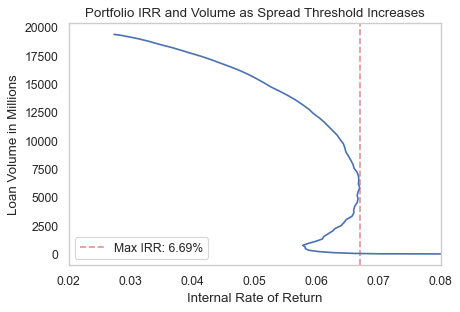

In [211]:
max_irr=results_spread[results_spread['volume_mm']>100]['irr'].max()
max_irr_label = ("{:.2f}%".format(max_irr*100))

plt.rcParams.update({'font.size': 10})
f, ax = plt.subplots()
ax.grid(False)
ax.plot(results_spread.irr, results_spread.volume_mm)
ax.set_ylabel('Loan Volume in Millions')
ax.set(xlabel="Internal Rate of Return", title="Portfolio IRR and Volume as Spread Threshold Increases")
ax.set_xlim([0.02, 0.08])
ax.axvline(max_irr, linestyle='--', color='r', label=('Max IRR: '+max_irr_label), alpha=0.6)
ax.legend(loc=3)
f.savefig('./images/spread_threshold_IRR.png', facecolor=f.get_facecolor(), transparent=True, dpi=500)

In [212]:
results_spread[results_spread['irr']==max_irr]

,min_t,irr,volume_mm
60,-0.23,0.07,5835.94


Our best spread threshold is for loans above -0.23 where we get an IRR of 6.69% and we were able to allocate 1,167 million dollars in loans over the course of the last 10 years.

## Loan Return Model - Catboost

Although the spread of a loan does seem to have a good correlation with the IRR we can obtain I will construct a model that directly tries to predict IRR using the default predictions from the loan default model and all the other data. This way we are directly optimizing the metric we are interested in, which is IRR.

In [213]:
def calculate_irr2(test_df):
    '''Calculates the annual IRR of a dataframe with a certain structure'''
    cf_df = test_df.loc[:,'01-2007':'03-2019'].apply(np.sum).reset_index()
    cf_df.columns = ['Date', 'CF']
    cf_df = cf_df[cf_df['CF']!=0]
    irr1 = npf.irr(cf_df["CF"])
    #Converting to yearly IRR
    irr1 = ((irr1+1)**12)-1
    return(irr1)

In [214]:
# for index in test_df.index:
#     irr = calculate_irr2(test_df.loc[index:index,:])
#     test_df.loc[index, 'irr'] = irr

KeyboardInterrupt: 

In [215]:
# test_df.to_pickle("G:\\Lending Club Data Files\\test_df.pkl")

In [216]:
test_df = pd.read_pickle("G:\\Lending Club Data Files\\test_df.pkl")

In [217]:
test_df.sample(1)

,id,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,zip_code,addr_state,dti,earliest_cr_line,fico_range_low,fico_range_high,open_acc,pub_rec,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint,pub_rec_bankruptcies,acc_now_delinq,acc_open_past_24mths,all_util,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,debt_settlement_flag,debt_settlement_flag_date,deferral_term,delinq_2yrs,delinq_amnt,desc,disbursement_method,emp_title,funded_amnt,funded_amnt_inv,hardship_amount,hardship_dpd,hardship_end_date,hardship_flag,hardship_last_payment_amount,hardship_length,hardship_loan_status,hardship_payoff_balance_amount,hardship_reason,hardship_start_date,hardship_status,hardship_type,il_util,inq_fi,inq_last_12m,inq_last_6mths,installment,issue_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,last_pymnt_amnt,last_pymnt_d,loan_status,max_bal_bc,member_id,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,next_pymnt_d,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,orig_projected_additional_accrued_interest,out_prncp,out_prncp_inv,payment_plan_start_date,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pymnt_plan,recoveries,revol_bal,revol_bal_joint,revol_util,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_earliest_cr_line,sec_app_fico_range_high,sec_app_fico_range_low,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_mths_since_last_major_derog,sec_app_num_rev_accts,sec_app_open_acc,sec_app_open_act_il,sec_app_revol_util,settlement_amount,settlement_date,settlement_percentage,settlement_status,settlement_term,tax_liens,title,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,proba_FP,proba_CO,nb_months,01-2007,02-2007,03-2007,04-2007,05-2007,06-2007,07-2007,08-2007,09-2007,10-2007,11-2007,12-2007,01-2008,02-2008,03-2008,04-2008,05-2008,06-2008,07-2008,08-2008,09-2008,10-2008,11-2008,12-2008,01-2009,02-2009,03-2009,04-2009,05-2009,06-2009,07-2009,08-2009,09-2009,10-2009,11-2009,12-2009,01-2010,02-2010,03-2010,04-2010,05-2010,06-2010,07-2010,08-2010,09-2010,10-2010,11-2010,12-2010,01-2011,02-2011,03-2011,04-2011,05-2011,06-2011,07-2011,08-2011,09-2011,10-2011,11-2011,12-2011,01-2012,02-2012,03-2012,04-2012,05-2012,06-2012,07-2012,08-2012,09-2012,10-2012,11-2012,12-2012,01-2013,02-2013,03-2013,04-2013,05-2013,06-2013,07-2013,08-2013,09-2013,10-2013,11-2013,12-2013,01-2014,02-2014,03-2014,04-2014,05-2014,06-2014,07-2014,08-2014,09-2014,10-2014,11-2014,12-2014,01-2015,02-2015,03-2015,04-2015,05-2015,06-2015,07-2015,08-2015,09-2015,10-2015,11-2015,12-2015,01-2016,02-2016,03-2016,04-2016,05-2016,06-2016,07-2016,08-2016,09-2016,10-2016,11-2016,12-2016,01-2017,02-2017,03-2017,04-2017,05-2017,06-2017,07-2017,08-2017,09-2017,10-2017,11-2017,12-2017,01-2018,02-2018,03-2018,04-2018,05-2018,06-2018,07-2018,08-2018,09-2018,10-2018,11-2018,12-2018,01-2019,02-2019,03-2019,spread,irr
89810,63155303,25000.00,60 months,17.57,D,D4,10+ years,MORTGAGE,83000.00,Source Verified,debt_consolidation,784xx,TX,18.44,Sep-1994,725.00,729.00,12.00,0.00,w,Individual,NaN,NaN,nan,0.00,0.00,7.00,NaN,11627.00,8154.00,42.30,0.00,0.00,0.00,N,NaN,NaN,0.00,0.00,NaN,Cash,800 Division Lead,25000.00,25000.00,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [218]:
for e, column in enumerate(test_df.columns):
    print (e, column)

0 id
1 loan_amnt
2 term
3 int_rate
4 grade
5 sub_grade
6 emp_length
7 home_ownership
8 annual_inc
9 verification_status
10 purpose
11 zip_code
12 addr_state
13 dti
14 earliest_cr_line
15 fico_range_low
16 fico_range_high
17 open_acc
18 pub_rec
19 initial_list_status
20 application_type
21 annual_inc_joint
22 dti_joint
23 verification_status_joint
24 pub_rec_bankruptcies
25 acc_now_delinq
26 acc_open_past_24mths
27 all_util
28 avg_cur_bal
29 bc_open_to_buy
30 bc_util
31 chargeoff_within_12_mths
32 collection_recovery_fee
33 collections_12_mths_ex_med
34 debt_settlement_flag
35 debt_settlement_flag_date
36 deferral_term
37 delinq_2yrs
38 delinq_amnt
39 desc
40 disbursement_method
41 emp_title
42 funded_amnt
43 funded_amnt_inv
44 hardship_amount
45 hardship_dpd
46 hardship_end_date
47 hardship_flag
48 hardship_last_payment_amount
49 hardship_length
50 hardship_loan_status
51 hardship_payoff_balance_amount
52 hardship_reason
53 hardship_start_date
54 hardship_status
55 hardship_type
56 il_

Using the dictionary with the descriptions I will review the features available to determine which were obtained after the loan origination to avoid data leakage. We should only use information available at loan origination in order to avoid having a model that overestimates its predictive power. The following are features I found to be available at origination and that are relevant:

- id, loan_amnt, term, int_rate, grade, sub_grade, emp_length, emp_title, home_ownership, annual_inc, verification_status, purpose, zip_code, addr_state, dti, earliest_cr_line, fico_range_low, fico_range_high, open_acc, pub_rec, initial_list_status, application_type, annual_inc_joint, dti_joint, verification_status_joint, pub_rec_bankruptcies, proba_FP, spread, irr (target).

In [219]:
df = test_df.loc[:,['id', 'loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_length', 'emp_title', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'initial_list_status', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'pub_rec_bankruptcies', 'proba_FP', 'spread', 'irr']]
df.sample(1)

,id,loan_amnt,term,int_rate,grade,sub_grade,emp_length,emp_title,home_ownership,annual_inc,verification_status,purpose,zip_code,addr_state,dti,earliest_cr_line,fico_range_low,fico_range_high,open_acc,pub_rec,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint,pub_rec_bankruptcies,proba_FP,spread,irr
570621,117857260,16400.00,36 months,7.07,A,A2,10+ years,Shop Forman,MORTGAGE,95000.00,Not Verified,debt_consolidation,173xx,PA,26.89,Aug-2000,740.00,744.00,10.00,0.00,w,Individual,NaN,NaN,nan,0.00,0.87,-0.06,0.07


###  Understanding and Dealing with the Missing Data

In [220]:
nullseries = df.isnull().sum()
nullseries[nullseries > 0].sort_values(ascending=False)

dti_joint               263506
annual_inc_joint        263505
emp_title                16995
irr                       4338
pub_rec_bankruptcies       136
dti                         77
dtype: int64

It seems most of the missing values for the joint data are missing because they do not apply since not all loan applicants do so with another person.

When IRR is missing it is because it got prepaid the same month as the loan was issued, and since we are calculating IRR on a monthly basis it cannot be calculated. Since, when the time between loan issued and loan prepaid approaches 0 the annual IRR goes to 0, I will assign the missing IRR to 0.

In [221]:
df['irr'] = df['irr'].fillna(value=0)

In [222]:
df.shape

(268602, 29)

### Feature Transformation and Dummyfing

Here we will prepare the data to be able to be properly fed into the models. Based on my research I have chosen to use CatBoost as it seems to have the best performance both on results and speeds. This model does not need much pre-processing of the data, for example categorical features have to be specified using an index instead of needing label encoding.

In [223]:
#Separating the target variable

X = df.drop('irr', axis=1)
y = df.irr

In [224]:
#Converting objects to strings

for column in X.columns:
    if (X[column].dtypes != float):
        X[column] = X[column].astype(str)

In [225]:
#Creating an index of the categorical features to point to the model
#print(X.dtypes)
cat_feat_index = np.where(X.dtypes != float)[0]
cat_feat_index

array([ 0,  2,  4,  5,  6,  7,  8, 10, 11, 12, 13, 15, 20, 21, 24],
      dtype=int64)

### Train Test Split

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=72)

### Training the model

In [227]:
# pool0 = Pool(X_train, y_train, cat_features=cat_feat_index)
# pool1 = Pool(X_test, y_test, cat_features=cat_feat_index)

# model2 = CatBoostRegressor(iterations=10000, learning_rate=0.03, early_stopping_rounds=50)

# model2.fit(X_train,
#           y_train,
#           eval_set=pool1,
#           cat_features=cat_feat_index,
#           verbose=False,
#           plot=True
#           )

### Results

Saving model to avoid retraining

In [228]:
# model2.save_model('G:\\Lending Club Data Files\\lending_club_catboost2')

In [229]:
model2 = CatBoostRegressor()
model2.load_model('G:\\Lending Club Data Files\\lending_club_catboost2')

In [230]:
#Separating the target variable

X = df.drop('irr', axis=1)
y = df.irr

In [231]:
#Converting objects to strings

for column in X.columns:
    if (X[column].dtypes != float):
        X[column] = X[column].astype(str)

In [232]:
#Creating an index of the categorical features to point to the model
#print(X.dtypes)
cat_feat_index = np.where(X.dtypes != float)[0]
cat_feat_index

array([ 0,  2,  4,  5,  6,  7,  8, 10, 11, 12, 13, 15, 20, 21, 24],
      dtype=int64)

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=72)

In [234]:
pool0 = Pool(X_train, y_train, cat_features=cat_feat_index)
pool1 = Pool(X_test, y_test, cat_features=cat_feat_index)

In [235]:
predictions = model2.predict(X_test)
print("The R2 Score is:")
print(round(model2.score(pool1),2))
print("The RMSE Score is:")
print(round(metrics.mean_squared_error(y_test, predictions, squared=False),2))

The R2 Score is:
0.06
The RMSE Score is:
0.31


Getting feature importance

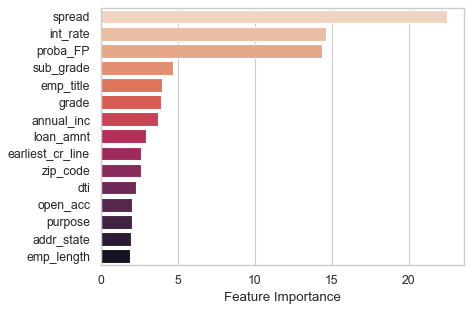

In [236]:
feature_importance = model2.get_feature_importance(prettified=True)

f, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance[0:15], palette="rocket_r")
ax.set(ylabel="",
       xlabel="Feature Importance")
plt.tight_layout()
f.savefig('./images/feature_imp_model2.png', dpi=500)

## Back Testing Loan Portfolios

### Creating a Dataframe with all the Relevant Information

We will recover all the data excluded because it was forward looking in order to properly be able to calculate the return function. Meaning we will get all the columns we excluded in the point "3.1 Selecting Features".

In [237]:
cols_to_use = test_df.columns.difference(X_test.columns, sort=False)

In [238]:
test_df2 = pd.merge(X_test, test_df[cols_to_use], how='left', left_index=True, right_index=True)

In [239]:
test_df2['irr_pred']=predictions

### IRR Calculation

In [240]:
subset = np.arange(0.005, 1.005, 0.005).tolist()

In [241]:
results_pred_irr = pd.DataFrame(columns=['percentile', 'irr','volume_mm'])
n_loans = test_df2.shape[0]
test_df3 = test_df2.sort_values(ascending=False, by='irr_pred')
num = 0

for percent in subset:
    irr_df = test_df3[:int(round((percent*n_loans),0))]
    # Volume is multiplied by 5 and 5 because the test set is actually 20% of 20% 
    # of the total size of the loans due to the train/test split of the two models
    volume = (irr_df['loan_amnt'].sum()/1000000)*5*5
    irr = calculate_irr(irr_df)
    results_pred_irr.loc[num] = [percent] + [irr] + [volume]
    num += 1

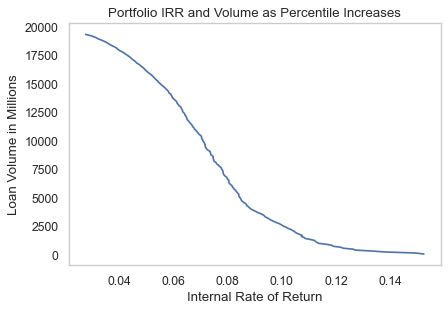

In [242]:
plt.rcParams.update({'font.size': 10})
f, ax = plt.subplots()
ax.grid(False)
ax.plot(results_pred_irr.irr, results_pred_irr.volume_mm)
ax.set_ylabel('Loan Volume in Millions')
ax.set(xlabel="Internal Rate of Return", title="Portfolio IRR and Volume as Percentile Increases")
# ax.set_xlim([0.02, 0.08])
f.savefig('./images/percentile_threshold_IRR.png', facecolor=f.get_facecolor(), transparent=True, dpi=500)

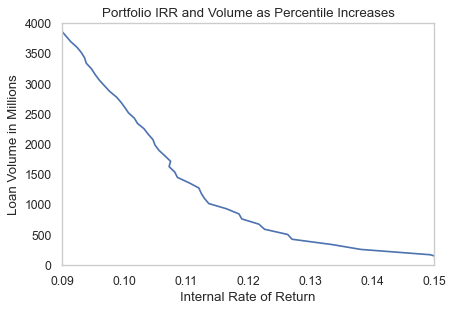

In [243]:
plt.rcParams.update({'font.size': 10})
f, ax = plt.subplots()
ax.grid(False)
ax.plot(results_pred_irr.irr, results_pred_irr.volume_mm)
ax.set_ylabel('Loan Volume in Millions')
ax.set(xlabel="Internal Rate of Return", title="Portfolio IRR and Volume as Percentile Increases")
ax.set_xlim([0.09,0.15])
ax.set_ylim([0,4000])
f.savefig('./images/percentile_threshold_IRR2.png', facecolor=f.get_facecolor(), transparent=True, dpi=500)

In [276]:
table = results_pred_irr.sort_values(by='irr',ascending=False).head(10)
table['percentile'] = ["{0:.2f}%".format(val * 100) for val in table['percentile']]
table['irr'] = ["{0:.2f}%".format(val * 100) for val in table['irr']]
table.columns = ['Percentile','IRR','Volume_MM']
table

,Percentile,IRR,Volume_MM
0,0.50%,15.25%,79.96
1,1.00%,14.94%,169.94
2,1.50%,13.82%,258.00
3,2.00%,13.35%,339.05
4,2.50%,12.71%,426.15
5,3.00%,12.64%,505.25
6,3.50%,12.27%,591.65
7,4.00%,12.18%,675.94
8,4.50%,11.90%,762.94
9,5.00%,11.85%,846.11


The previous table can be used by the investment firm to decide weather to allocate its funds based on a IRR objective and/or a loan budget constraint.

At this IRR, this investment asset, when properly allocated into the right loans, can be a very attractive alternative. The S&P 500 has had an average return of around 10.7% for the last 30 years and 13.9% for the last 10. An investment firm could get similar or higher returns on a diversified portfolio of loans by investing in this type of asset from Lending Club, which depending on the risk profile of the fund, might be more than adequate 